In [64]:
# imports
from tueplots import bundles
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import isfile



In [65]:
plt.rcParams.update(bundles.neurips2022(usetex=False))

In [66]:
# Constants
ENTITY = "ima-vae"
PROJECT = "priors"
SWEEP_ID = "7xhucpph"


In [67]:
api = wandb.Api(timeout=200)
runs = api.runs(ENTITY + "/" + PROJECT)

sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
sweep_runs = sweep.runs

In [143]:
data = []
filename = f"moebius_sweep_data_{SWEEP_ID}.csv"
max_dim = -1
if not isfile(filename):
    for run in sweep_runs:

        if True or (run.state == 'finished' or ('decoder_var' in run.config.keys() and run.config['decoder_var']>= 0.1)) and f'Metrics/val/latent_statistics.latent_variance_0' in run.history().keys():

            # .summary contains the output keys/values for metrics like accuracy.
            #  We call ._json_dict to omit large files
            summary = run.summary._json_dict

            # .config contains the hyperparameters.
            #  We remove special values that start with _.
            config = {k: v for k,v in run.config.items()
                 if not k.startswith('_')}







            dim = config['latent_dim']
            sigmas = run.history(keys=[f'Metrics/val/latent_statistics.latent_variance_{i}' for i in range(dim)]).iloc[-1].to_numpy()[1:]
            col_norms_sq = [run.summary._json_dict[f"Metrics/val/col_norm_{i}"] for i in range(dim)]
            mcc = summary['Metrics/val/mcc']
            cima = summary['Metrics/val/cima']
            gamma_square = 1. / config['decoder_var']
            prior = config['model.prior']

            rhs = (1./(float(prior=="gaussian")+gamma_square*np.array(col_norms_sq)))

            if dim > max_dim:
                max_dim = dim


            data.append([run.name, dim, gamma_square, prior, cima, mcc, *sigmas, *col_norms_sq, *rhs])





    runs_df = pd.DataFrame(data, columns=["name", "dim", "gamma_square", "prior", "cima", "mcc", *[f"sigma_{i}" for i in range(max_dim)],
                                          *[f"col_norm_sq_{i}" for i in range(max_dim)], *[f"rhs_{i}" for i in range(max_dim)]  ] ).fillna(0)

    # runs_df.to_csv(filename)
else:
    runs_df = pd.read_csv(filename)

In [144]:
runs_df

,name,dim,gamma_square,prior,cima,mcc,sigma_0,sigma_1,sigma_2,sigma_3,...,col_norm_sq_0,col_norm_sq_1,col_norm_sq_2,col_norm_sq_3,col_norm_sq_4,rhs_0,rhs_1,rhs_2,rhs_3,rhs_4
0,fallen-sweep-25,5,1.000000e+10,gaussian,0.667452,0.709070,2.595902e-08,1.155837e-08,2.482836e-08,2.644604e-08,...,0.258279,0.400661,0.319585,0.374215,0.354913,3.871784e-10,2.495879e-10,3.129054e-10,2.672263e-10,2.817589e-10
1,worldly-sweep-24,5,1.000000e+10,gaussian,0.463907,0.654447,1.859328e-08,8.960117e-09,1.589889e-08,2.066163e-08,...,0.315877,0.315104,0.332692,0.247089,0.321685,3.165789e-10,3.173554e-10,3.005783e-10,4.047129e-10,3.108629e-10
2,fiery-sweep-23,5,1.000000e+10,gaussian,0.396576,0.677676,6.258851e-08,7.430008e-08,2.248548e-08,2.008862e-08,...,0.184565,0.292605,0.298297,0.332140,0.366912,5.418140e-10,3.417575e-10,3.352368e-10,3.010778e-10,2.725453e-10
3,eager-sweep-22,5,1.000000e+10,gaussian,0.379294,0.704590,7.967735e-09,1.488689e-08,5.945244e-09,1.001127e-08,...,0.295213,0.387395,0.330807,0.286891,0.247178,3.387382e-10,2.581343e-10,3.022912e-10,3.485643e-10,4.045665e-10
4,spring-sweep-21,5,1.000000e+10,gaussian,0.546718,0.655716,6.817285e-08,1.586392e-08,1.930709e-08,5.329141e-08,...,0.220614,0.316872,0.307056,0.280917,0.263232,4.532798e-10,3.155849e-10,3.256730e-10,3.559769e-10,3.798933e-10
5,curious-sweep-20,5,1.000000e+05,gaussian,0.030453,0.710214,3.011240e-04,1.000231e-04,9.092663e-05,1.541095e-04,...,0.184768,0.323182,0.334601,0.253259,0.330968,5.411908e-05,3.094135e-05,2.988541e-05,3.948367e-05,3.021350e-05
6,decent-sweep-18,5,1.000000e+05,gaussian,0.116998,0.693050,4.622978e-04,1.857566e-04,1.228290e-04,8.051530e-05,...,0.149505,0.237244,0.286362,0.356173,0.300188,6.688301e-05,4.214889e-05,3.491960e-05,2.807545e-05,3.331130e-05
7,faithful-sweep-17,5,1.000000e+05,gaussian,0.021756,0.759523,1.277666e-04,6.934060e-05,9.666847e-05,2.090518e-04,...,0.278809,0.376200,0.322754,0.224364,0.190203,3.586558e-05,2.658089e-05,3.098234e-05,4.456849e-05,5.257255e-05
8,young-sweep-14,5,1.000000e+04,gaussian,0.000654,0.731153,1.987016e-03,1.108793e-03,1.032318e-03,1.037809e-03,...,0.219858,0.294093,0.305255,0.307558,0.407731,4.546312e-04,3.399131e-04,3.274873e-04,3.250361e-04,2.451999e-04
9,fast-sweep-13,5,1.000000e+04,gaussian,0.000499,0.813865,8.581762e-04,5.051512e-04,7.526141e-04,8.598055e-04,...,0.334634,0.437014,0.362948,0.340925,0.364275,2.987442e-04,2.287733e-04,2.754455e-04,2.932340e-04,2.744428e-04


$$ \sigma_k^2 (x) = \left(-n''(\mu_k^\phi(x)) + \gamma^2 \left\Vert \left[ J_f(g(x))\right]_{:k}\right\Vert^2\right)^{-1} $$

In [145]:
runs_df[[ "mcc", "gamma_square"]].groupby("gamma_square").describe()

mcc                                                    \
             count      mean       std       min       25%       50%   
gamma_square                                                           
1.000000e+01   5.0  0.179788  0.014911  0.163374  0.164102  0.187706   
1.000000e+03   5.0  0.586908  0.038693  0.540711  0.551248  0.600174   
1.000000e+04   5.0  0.737509  0.072944  0.639990  0.698713  0.731153   
1.000000e+05   5.0  0.699141  0.043279  0.638616  0.693050  0.694304   
1.000000e+10   5.0  0.680300  0.025968  0.654447  0.655716  0.677676   

                                  
                   75%       max  
gamma_square                      
1.000000e+01  0.188822  0.194938  
1.000000e+03  0.615988  0.626418  
1.000000e+04  0.803822  0.813865  
1.000000e+05  0.710214  0.759523  
1.000000e+10  0.704590  0.709070

In [146]:
runs_df[[ "cima", "gamma_square"]].groupby("gamma_square").describe()

cima                                                    \
             count      mean       std       min       25%       50%   
gamma_square                                                           
1.000000e+01   5.0  3.539720  0.801524  2.558931  3.218344  3.269316   
1.000000e+03   5.0  0.006060  0.000995  0.004820  0.005745  0.005789   
1.000000e+04   5.0  0.000714  0.000367  0.000370  0.000499  0.000654   
1.000000e+05   5.0  0.041851  0.042613  0.011963  0.021756  0.028086   
1.000000e+10   5.0  0.490789  0.118709  0.379294  0.396576  0.463907   

                                  
                   75%       max  
gamma_square                      
1.000000e+01  4.013811  4.638198  
1.000000e+03  0.006435  0.007512  
1.000000e+04  0.000721  0.001324  
1.000000e+05  0.030453  0.116998  
1.000000e+10  0.546718  0.667452

{'bodies': [<matplotlib.collections.PolyCollection at 0x123c28ca0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x123c32160>,
 'cmins': <matplotlib.collections.LineCollection at 0x123c14ca0>,
 'cbars': <matplotlib.collections.LineCollection at 0x123c14940>}

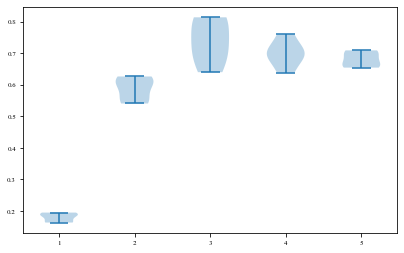

In [147]:
groups = [g.mcc for _, g in runs_df[[ "mcc", "gamma_square"]].groupby("gamma_square")]
plt.violinplot(groups)

In [115]:
groups = [(np.abs(np.array(g.lhs-g.rhs))) for _, g in runs_df[[ *[col for col in runs_df.columns if "rhs" in col], *[col for col in runs_df.columns if "rhs" in col],  "gamma_square"]].groupby("gamma_square")]

In [156]:
df_rhs = pd.DataFrame(runs_df[[col for col in runs_df.columns if "rhs" in col]].stack().droplevel(1), columns=["rhs"])
df_lhs = pd.DataFrame(runs_df[[col for col in runs_df.columns if "sigma" in col]].stack().droplevel(1), columns=["lhs"])

In [157]:
df_rhs_lhs_gamma_sq = df_rhs.merge( df_lhs, left_index=True, right_index=True).merge(runs_df["gamma_square"], left_index=True, right_index=True)

{'bodies': [<matplotlib.collections.PolyCollection at 0x123a340d0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x123a342b0>,
 'cmins': <matplotlib.collections.LineCollection at 0x123e56c70>,
 'cbars': <matplotlib.collections.LineCollection at 0x123e56400>}

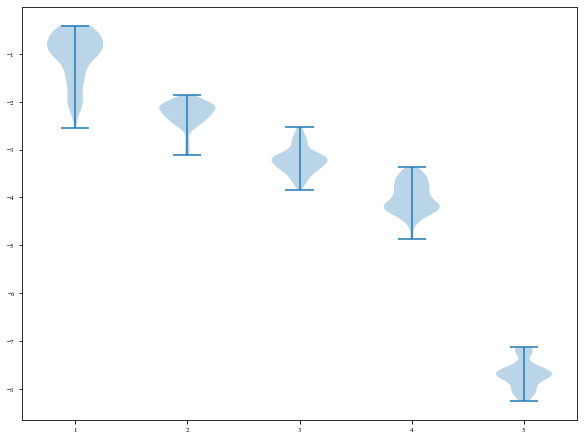

In [168]:
groups = [np.log10((g.lhs-g.rhs).abs()) for _, g in df_rhs_lhs_gamma_sq.groupby("gamma_square")]
plt.figure(figsize=(8,6))
plt.violinplot(groups)

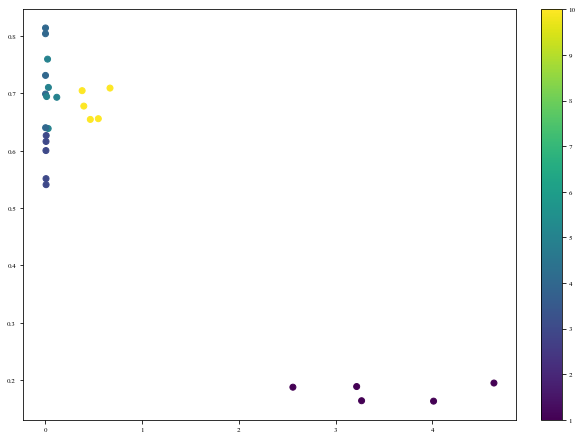

In [170]:
plt.figure(figsize=(8,6))
plt.scatter(runs_df["cima"], runs_df[ "mcc"], c=np.log10(runs_df["gamma_square"]))
plt.colorbar()

{'bodies': [<matplotlib.collections.PolyCollection at 0x1230d10d0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x1230cffd0>,
 'cmins': <matplotlib.collections.LineCollection at 0x1230c14f0>,
 'cbars': <matplotlib.collections.LineCollection at 0x1230c18e0>}

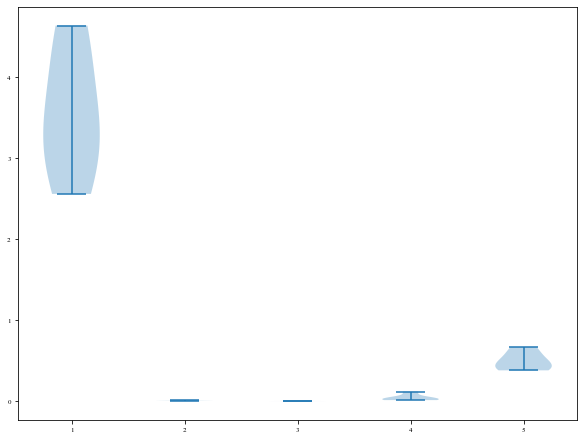

In [171]:
groups = [g.cima for _, g in runs_df[[ "cima", "gamma_square"]].groupby("gamma_square")]
plt.figure(figsize=(8,6))
plt.violinplot(groups)

In [25]:
ext_gamma_sq = [g*np.ones((d, 1)) for g,d in zip(gamma_sq, dim)]

In [26]:
def lhs_rhs(col_norm_squared, priors, variances, gamma_squared, ext_gamma_squared, prior_name):
    lhs = [s for s,p in zip(variances,priors) if p == prior_name]
    rhs = [1./(float(prior_name=="gaussian")+g_sq*J_sq) for g_sq, J_sq, p in zip(gamma_squared, col_norm_squared, priors) if p == prior_name]
    gamma = np.array([g for g,p in zip(gamma_squared, priors) if p == prior_name])
    gamma_ext = np.concatenate([g for g,p in zip(ext_gamma_squared, priors) if p == prior_name])

    abs_diff = np.abs(np.concatenate(lhs)-np.concatenate(rhs))
    lhs_rhs_vs_gamma =[ np.array([d for d, g in zip(abs_diff, gamma_ext) if g==gamma_select]) for gamma_select in np.unique(gamma_ext)  ]

    return lhs, rhs, gamma_ext, gamma, abs_diff, lhs_rhs_vs_gamma

In [47]:
lhs_gauss ,rhs_gauss,gamma_gauss_ext,  gamma_gauss, abs_diff_gauss, lhs_rhs_vs_gamma_gauss = lhs_rhs(col_norm_sq, prior, sigmas, gamma_sq, ext_gamma_sq, "gaussian")
lhs_laplace ,rhs_laplace,gamma_laplace_ext, gamma_laplace,  abs_diff_laplace, lhs_rhs_vs_gamma_laplace = lhs_rhs(col_norm_sq, prior, sigmas, gamma_sq,  ext_gamma_sq,"laplace")
lhs_uniform ,rhs_uniform,gamma_uniform_ext, gamma_uniform,  abs_diff_uniform, lhs_rhs_vs_gamma_uniform = lhs_rhs(col_norm_sq, prior, sigmas, gamma_sq,  ext_gamma_sq,"uniform")

In [48]:
def violin_by_prior(gauss_data, laplace_data, uniform_data, xticks, xlabel, ylabel,  offset, filename, figsize=(8,6), log=False):

    plt.figure(figsize=figsize)
    vp_gauss = plt.violinplot([np.log10(i) if log is True else i for i in gauss_data], positions=xticks)
    vp_laplace = plt.violinplot([np.log10(i) if log is True else i for i in laplace_data], positions=-offset+xticks)
    vp_uniform= plt.violinplot([np.log10(i) if log is True else i for i in uniform_data], positions=offset+xticks)
    plt.legend([vp_gauss['bodies'][0],vp_laplace['bodies'][0], vp_uniform['bodies'][0]], ['gaussian', 'laplace', 'uniform'], loc='upper right')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(xticks)
    # plt.tight_layout()
    plt.savefig(filename)

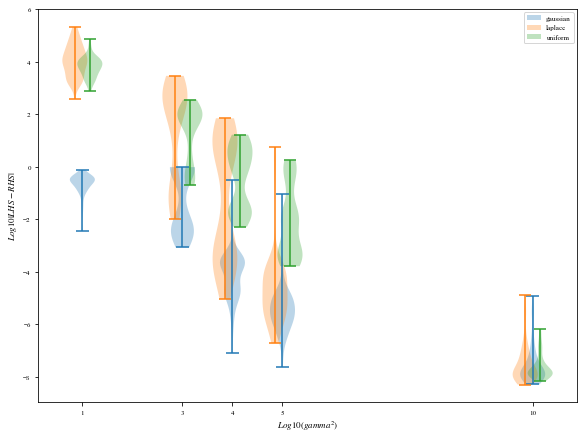

In [49]:
violin_by_prior(lhs_rhs_vs_gamma_gauss, lhs_rhs_vs_gamma_laplace, lhs_rhs_vs_gamma_uniform,  np.unique(np.log10(gamma_uniform_ext)), '$Log10(gamma^2)$', '$Log10|LHS-RHS|$',  0.15, 'opt_sigma_vs_gamma', log=True)

In [50]:
def cima_mcc(cimas, mccs, dims, priors,  prior_name):
    cima = np.array([c for c,p in zip(cimas, priors) if p == prior_name])
    mcc = np.array([m for m,p in zip(mccs, priors) if p == prior_name])
    dim = np.array([d for d,p in zip(dims, priors) if p == prior_name])


    cima_vs_dim = [ np.array([c for d, c in zip(dim, cima) if d==dim_select]) for dim_select in np.unique(dim)  ]
    mcc_vs_dim = [ np.array([m for d, m in zip(dim, mcc) if d==dim_select]) for dim_select in np.unique(dim)  ]

    return cima, mcc, dim, cima_vs_dim, mcc_vs_dim

In [51]:
cima_gauss, mcc_gauss, dim_gauss, cima_vs_dim_gauss, mcc_vs_dim_gauss = cima_mcc(cima, mcc, dim, prior, "gaussian")
cima_laplace, mcc_laplace, dim_laplace, cima_vs_dim_laplace, mcc_vs_dim_laplace = cima_mcc(cima, mcc, dim, prior, "laplace")
cima_uniform, mcc_uniform, dim_uniform, cima_vs_dim_uniform, mcc_vs_dim_uniform = cima_mcc(cima, mcc, dim, prior, "uniform")

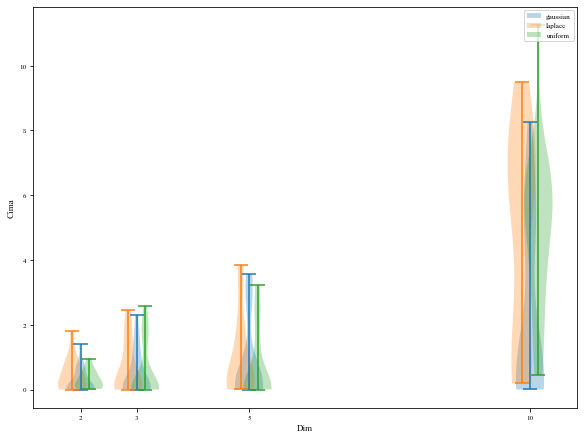

In [32]:
violin_by_prior(cima_vs_dim_gauss, cima_vs_dim_laplace, cima_vs_dim_uniform,  np.unique(dim), 'Dim', 'Cima',  0.15, 'cima_vs_dim')

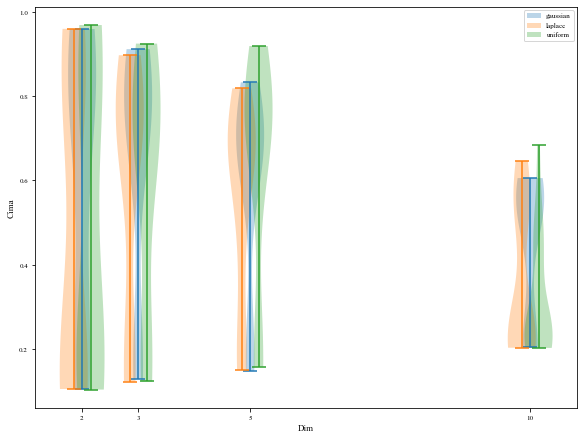

In [33]:
violin_by_prior(mcc_vs_dim_gauss, mcc_vs_dim_laplace, mcc_vs_dim_uniform,  np.unique(dim), 'Dim', 'Cima',  0.15, 'mcc_vs_dim')

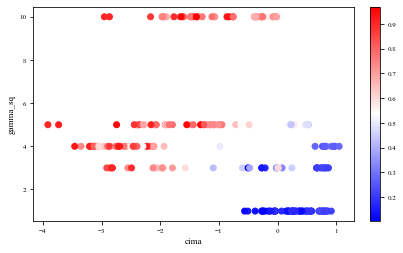

In [34]:
plt.scatter(np.log10(cima), np.log10(gamma_sq),c=mcc,cmap='bwr',)
plt.xlabel('cima')
plt.ylabel('gamma_sq')
plt.colorbar()

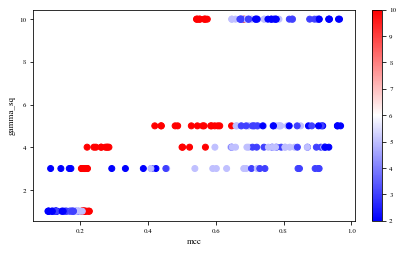

In [35]:
plt.scatter(mcc, np.log10(gamma_sq), c=dim,cmap='bwr',)
plt.xlabel('mcc')
plt.ylabel('gamma_sq')
plt.colorbar()

In [36]:
cima_vs_dim = [ np.array([c for d, c in zip(dim, cima) if d==dim_select]) for dim_select in np.unique(np.array(dim))  ]
mcc_vs_dim = [ np.array([m for d, m in zip(dim, mcc) if d==dim_select]) for dim_select in np.unique(np.array(dim))  ]

{'bodies': [<matplotlib.collections.PolyCollection at 0x1207d5a30>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x12076ec40>,
 'cmins': <matplotlib.collections.LineCollection at 0x124587eb0>,
 'cbars': <matplotlib.collections.LineCollection at 0x124587100>}

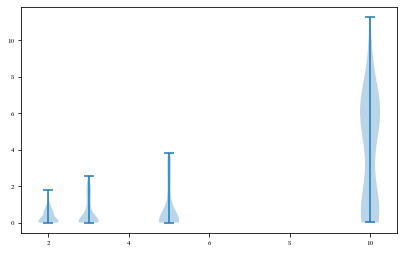

In [37]:
plt.violinplot(cima_vs_dim, positions=np.unique(np.array(dim)))

In [38]:
markers = ['o' if p=="gauss" else '^' if p=='laplace' else 's' for p in prior]

/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_55960/2388439361.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_55960/2388439361.py:9: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


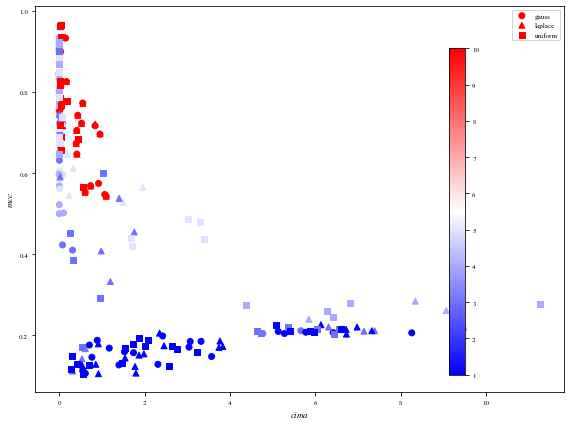

In [39]:
plt.figure(figsize=(8,6))
plt.scatter((cima_gauss),(mcc_gauss), c=np.log10(gamma_gauss),cmap='bwr', marker='o', label='gauss')
plt.scatter((cima_laplace),(mcc_laplace), c=np.log10(gamma_laplace),cmap='bwr', marker='^', label='laplace')
plt.scatter((cima_uniform),(mcc_uniform), c=np.log10(gamma_uniform),cmap='bwr', marker='s', label='uniform')
plt.xlabel("$cima$")
plt.ylabel("$mcc$")
plt.colorbar()
plt.legend()
plt.tight_layout()
plt.savefig('cima_vs_mcc')

In [58]:
gauss_mcc_vs_gamma = [ np.array([m,g]) for (g, m, d) in zip(gamma_gauss, mcc_gauss, dim_gauss) if d == 5]
gauss_mcc_vs_gamma_violin = [ np.array([m for m, g in gauss_mcc_vs_gamma if g==gamma_select]) for gamma_select in np.unique(gamma_gauss)  ]

In [60]:
np.unique(gamma_gauss)

array([1.e+01, 1.e+03, 1.e+04, 1.e+05, 1.e+10])

{'bodies': [<matplotlib.collections.PolyCollection at 0x126617d60>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x126617280>,
 'cmins': <matplotlib.collections.LineCollection at 0x126638b80>,
 'cbars': <matplotlib.collections.LineCollection at 0x1266179a0>}

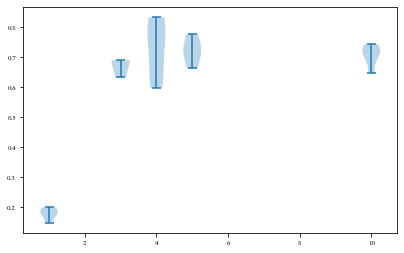

In [61]:
plt.violinplot(gauss_mcc_vs_gamma_violin, positions=np.log10(np.unique(gamma_gauss)))

In [62]:
gauss_cima_vs_gamma = [ np.array([m,g]) for (g, m, d) in zip(gamma_gauss, cima_gauss, dim_gauss) if d == 5]
gauss_cima_vs_gamma_violin = [ np.array([m for m, g in gauss_cima_vs_gamma if g==gamma_select]) for gamma_select in np.unique(gamma_gauss)  ]

{'bodies': [<matplotlib.collections.PolyCollection at 0x126615520>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x126615a60>,
 'cmins': <matplotlib.collections.LineCollection at 0x126626a00>,
 'cbars': <matplotlib.collections.LineCollection at 0x12662d5e0>}

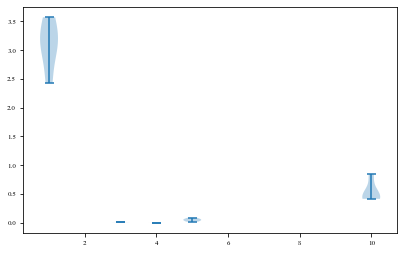

In [63]:
plt.violinplot(gauss_cima_vs_gamma_violin, positions=np.log10(np.unique(gamma_gauss)))